In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import psyneulink as pnl
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import sys; sys.path.append('./shape-naming/')
import shape_naming_model

In [4]:
model = shape_naming_model.ShapeNamingModel(2)

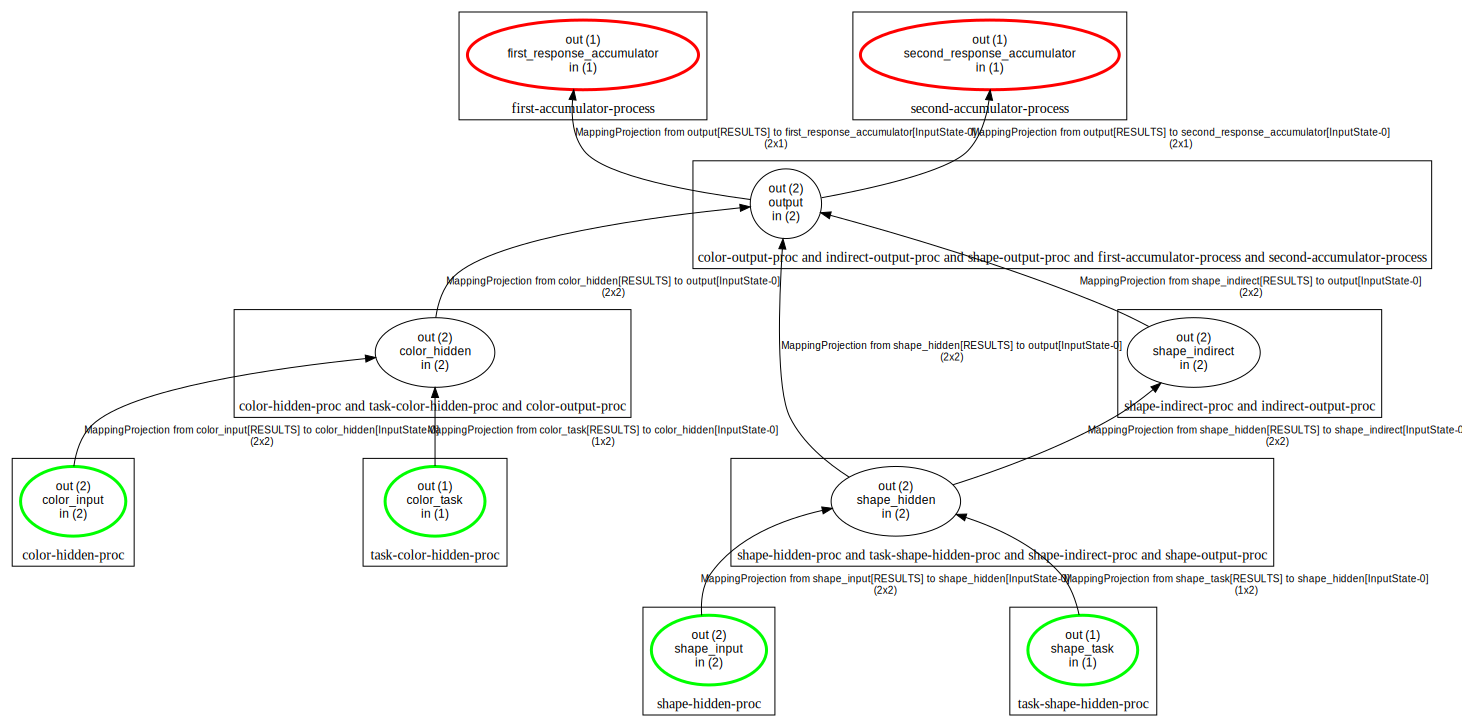

In [6]:
model.system.show_graph(show_dimensions=pnl.ALL, show_projection_labels=pnl.ALL, show_processes=pnl.ALL, output_fmt='jupyter')

In [7]:
model.train()

[[array([-0.11486811]), array([-0.04884925])],
 [array([-0.0650864]), array([-0.08080444])],
 [array([-0.04112539]), array([0.04100713])],
 [array([-0.05926394]), array([-0.21077475])],
 [array([-0.04928818]), array([-0.02010669])],
 [array([0.00940202]), array([0.01377994])],
 [array([0.18995431]), array([0.07545296])],
 [array([0.10659498]), array([-0.19419666])],
 [array([-0.0325887]), array([0.00107002])],
 [array([-0.07141701]), array([0.07051553])],
 [array([-0.0970008]), array([-0.04200414])],
 [array([0.1001919]), array([0.0652576])],
 [array([0.08272729]), array([-0.07224749])],
 [array([0.06684147]), array([-0.19845162])],
 [array([0.06349983]), array([0.08668977])],
 [array([-0.11348843]), array([0.03119878])],
 [array([-0.08114907]), array([0.04120122])],
 [array([-0.04257222]), array([0.04922217])],
 [array([0.03549225]), array([-0.01629844])],
 [array([0.05097401]), array([0.0318767])],
 [array([-0.16239918]), array([0.0114143])],
 [array([0.16268478]), array([0.01999203]

In [8]:
first_test_results = model.test()

In [10]:
shape_naming_results, color_naming_results, run_shape_naming_first = first_test_results

In [13]:
for key in shape_naming_results:
    print(key, np.average(shape_naming_results[key]))

conflict 58.375
congruent 52.583333333333336
control 48.604166666666664


In [14]:
for key in shape_naming_results:
    print(key, np.average(color_naming_results[key]))

conflict 33.145833333333336
congruent 28.375
control 33.791666666666664


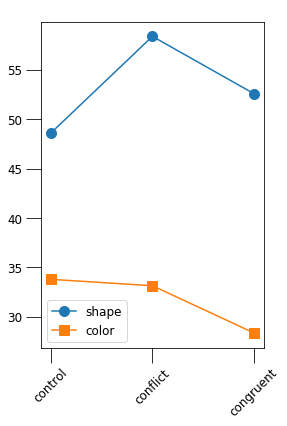

In [22]:
plt.figure(figsize=(4, 6))

ordered_keys = ('control', 'conflict', 'congruent')
shape_naming_averages = [np.average(shape_naming_results[key]) for key in ordered_keys]
color_naming_averages = [np.average(color_naming_results[key]) for key in ordered_keys]
                                    
x_values = np.arange(3)

pl1 = plt.plot(x_values, shape_naming_averages, marker='o', markersize=10, label='shape')
pl2 = plt.plot(x_values, color_naming_averages, marker='s', markersize=10, label='color')

plt.xticks(x_values, ordered_keys, rotation=45)
plt.tick_params(length=15, labelsize=12)
plt.legend(fontsize=12)
plt.show()